In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN import *
from NN_library.train_primal_VPINN import *
from NN_library.train_dual_VPINN import *
from matplotlib.tri import Triangulation
from utility import *
%load_ext autoreload
%autoreload 2

Using device: cuda


In [2]:
data = dataset_grid(129, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 129**2)

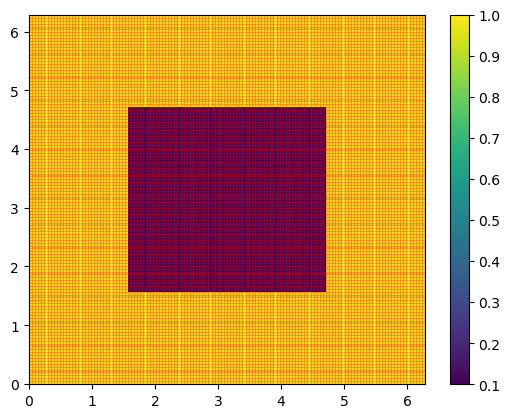

In [3]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

def a_function(x,y):
    a = np.where((x>np.pi/2)&(x<3*np.pi/2)&(y>np.pi/2)&(y<3*np.pi/2), 0.1, 1)
    return a

def A(x):
    a = torch.where((x[:,0]>torch.pi/2)&(x[:,0]<3*torch.pi/2)&(x[:,1]>torch.pi/2)&(x[:,1]<3*torch.pi/2), 0.1, 1).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def A_inv(x):  
    a = torch.where((x[:,0]>torch.pi/2)&(x[:,0]<3*torch.pi/2)&(x[:,1]>torch.pi/2)&(x[:,1]<3*torch.pi/2), 0.1, 1).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = (1 / a) * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

Z = a_function(XY[0].flatten(), XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.1, c='r')

# Test functions

## NN-based

In [13]:
N_test = 400
torch.manual_seed(0)
test_functions = [PINN(n_periodic=25, n_hidden=50, n_layers=5, period_len=L).to(dev) for i in range(N_test)]

In [14]:
# compute G if needed
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(dev)
x = x.to(dev).requires_grad_(True)

G = torch.zeros((N_test, N_test))
g_test = []
for i in range(N_test):
    y_test = test_functions[i](x)
    grad_test = torch.autograd.grad(
                outputs=y_test, inputs=x,
                grad_outputs=torch.ones_like(y_test)
            )[0]
    g_test.append(grad_test.detach())

for i in range(N_test):
    for j in range(i, N_test):
        intgr = compute_int(areas, tri, g_test[i], g_test[j])
        G[i,j] = intgr
        G[j,i] = intgr

#for i in range(N_test):
    #intgr = compute_int(areas, tri, g_test[i], g_test[i]).detach()
    #G[i,i] = intgr

torch.save(G, "G_primal_15601.pt")
G_inv = torch.linalg.inv(G).to(dev)

In [ ]:
eig, eigvec = torch.linalg.eigh(G)
eig_0 = torch.where(eig < 0, 0, eig)
G_spd = eigvec @ torch.diag(eig_0)

In [ ]:
G = torch.load("G_primal_15601.pt")[:N_test,:N_test]
G_inv = torch.linalg.inv(G).to(dev)

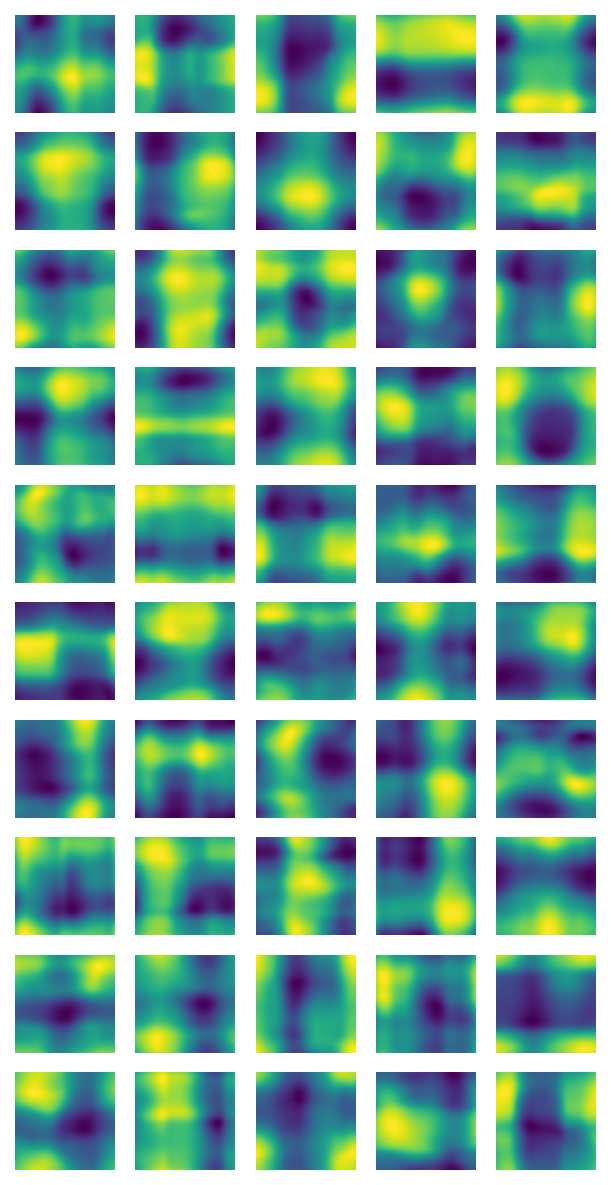

In [8]:
fig, axs = plt.subplots(nrows=10, ncols=N_test//10, figsize=(N_test//10,10), dpi=150)
for i in range(len(test_functions)):
    axs.flat[i].pcolormesh(XY[0], XY[1], test_functions[i](grid_data).reshape(N, N).cpu().detach())
    axs.flat[i].set_axis_off()

# Primal PINN

In [20]:
net_primal = PINN(n_periodic=25, n_hidden=50, n_layers=5, period_len=L)
total_params = sum(p.numel() for p in net_primal.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 1e-5, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VNPINN_primal_{total_params}_{N_test}'}

Number of parameters: 15601


In [19]:
net_primal = load_network(net_primal, args['name']+'_39999', args)
net_primal = net_primal.to(dev)

In [21]:
losses_train, losses_val = train_primal(net_primal, loaders, args, A, H1, test_functions, G_inv, L)

Epoch: 0 mean train loss:  2.89651537e+00, mean val. loss:  7.81538188e-01
Epoch: 1 mean train loss:  2.91049194e+00, mean val. loss:  7.81213224e-01
Epoch: 2 mean train loss:  2.88783455e+00, mean val. loss:  7.80889034e-01
Epoch: 3 mean train loss:  2.88227630e+00, mean val. loss:  7.80566454e-01
Epoch: 4 mean train loss:  2.89313579e+00, mean val. loss:  7.80244887e-01
Epoch: 5 mean train loss:  2.85744047e+00, mean val. loss:  7.79924750e-01
Epoch: 6 mean train loss:  2.85993290e+00, mean val. loss:  7.79606342e-01
Epoch: 7 mean train loss:  2.86096120e+00, mean val. loss:  7.79289246e-01
Epoch: 8 mean train loss:  2.85704350e+00, mean val. loss:  7.78973341e-01
Epoch: 9 mean train loss:  2.84191632e+00, mean val. loss:  7.78658867e-01
Epoch: 10 mean train loss:  2.81722975e+00, mean val. loss:  7.78345644e-01
Epoch: 11 mean train loss:  2.82066536e+00, mean val. loss:  7.78034151e-01
Epoch: 12 mean train loss:  2.82095814e+00, mean val. loss:  7.77723789e-01
Epoch: 13 mean train l

In [ ]:
np.save(f'NN_library/training_data/square/VNPINN_primal_{total_params}_{N_test}', np.vstack([losses_train, losses_val]))

In [ ]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [ ]:
U1 = net_primal(grid_data).detach().cpu()
error_1, _ = PDE_loss(grid_data, net_primal, A, H1)

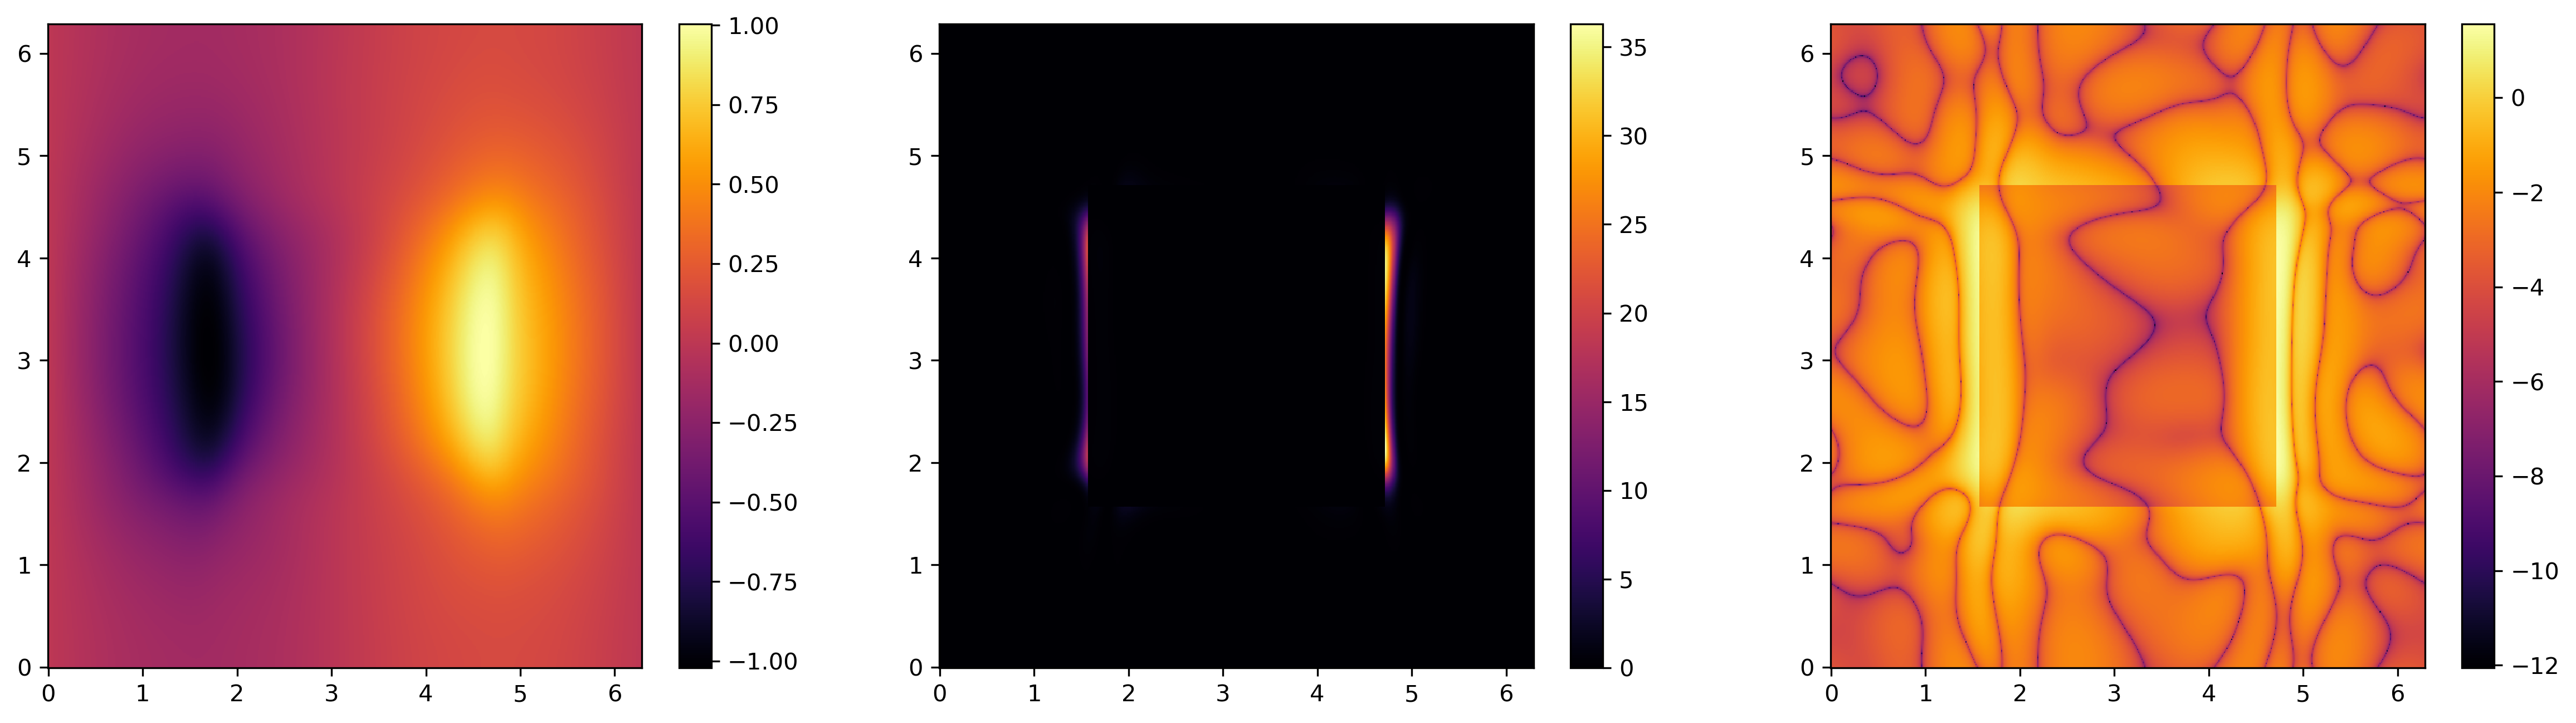

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1.reshape(N, N).detach().cpu(), cmap='inferno')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], np.log10(error_1.reshape(N, N).detach().cpu()), cmap='inferno')
fig.colorbar(pos3, ax=axs[2])

In [ ]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])
x_rot = torch.fliplr(x)

_, q1, gH = PDE_loss(x, net_primal, A, H1)
bound_1 = compute_estimate(areas, tri, q1, gH, L).detach()[0].item()
print(bound_1)

U1 = net_primal(x)
U2 = net_primal(x_rot)

bound_2 = compute_bound_primal(U1, U2, tri, x, A, L)[0,0]
print(bound_2)

np.save(f'bounds/square/A_u_VNPINN_{total_params}_{N_test}.npy', (bound_1, bound_2))

0.6689761877059937
0.6604634410883189


# Dual PINN

In [ ]:
net_dual = PINN(n_periodic=25, n_hidden=50, n_layers=5, period_len=L)
total_params = sum(p.numel() for p in net_dual.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.00001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VNPINN_dual_{total_params}_{N_test}'}

Number of parameters: 15601


In [28]:
net_dual = load_network(net_dual, args['name']+'_39999', args)
net_dual = net_dual.to(dev)

In [ ]:
losses_train, losses_val = train_dual(net_dual, loaders, args, A_inv, H1, test_functions, G_inv, L)

Epoch: 0 mean train loss:  1.01395938e+04, mean val. loss:  3.02247673e-01
Epoch: 1 mean train loss:  1.01102607e+04, mean val. loss:  3.02584201e-01
Epoch: 2 mean train loss:  1.00810029e+04, mean val. loss:  3.02920610e-01
Epoch: 3 mean train loss:  1.00518242e+04, mean val. loss:  3.03256780e-01
Epoch: 4 mean train loss:  1.00227217e+04, mean val. loss:  3.03592712e-01
Epoch: 5 mean train loss:  9.99370117e+03, mean val. loss:  3.03928494e-01
Epoch: 6 mean train loss:  9.96476074e+03, mean val. loss:  3.04263949e-01
Epoch: 7 mean train loss:  9.93590234e+03, mean val. loss:  3.04599226e-01
Epoch: 8 mean train loss:  9.90712598e+03, mean val. loss:  3.04934204e-01
Epoch: 9 mean train loss:  9.87843262e+03, mean val. loss:  3.05268884e-01
Epoch: 10 mean train loss:  9.84982129e+03, mean val. loss:  3.05603296e-01
Epoch: 11 mean train loss:  9.82129492e+03, mean val. loss:  3.05937350e-01
Epoch: 12 mean train loss:  9.79285156e+03, mean val. loss:  3.06271046e-01
Epoch: 13 mean train l

KeyboardInterrupt: 

In [44]:
np.save(f'NN_library/training_data/square/VNPINN_dual_{total_params}_{N_test}', np.vstack([losses_train, losses_val]))

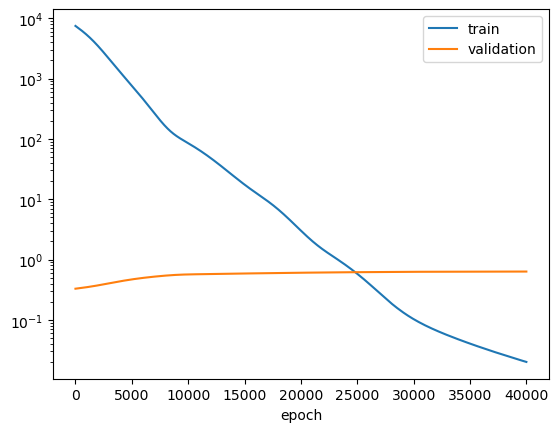

In [43]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [10]:
U2 = net_dual(grid_data).detach().cpu()
error_2, _ = PDE_loss_dual(grid_data, net_dual, A_inv, H1)

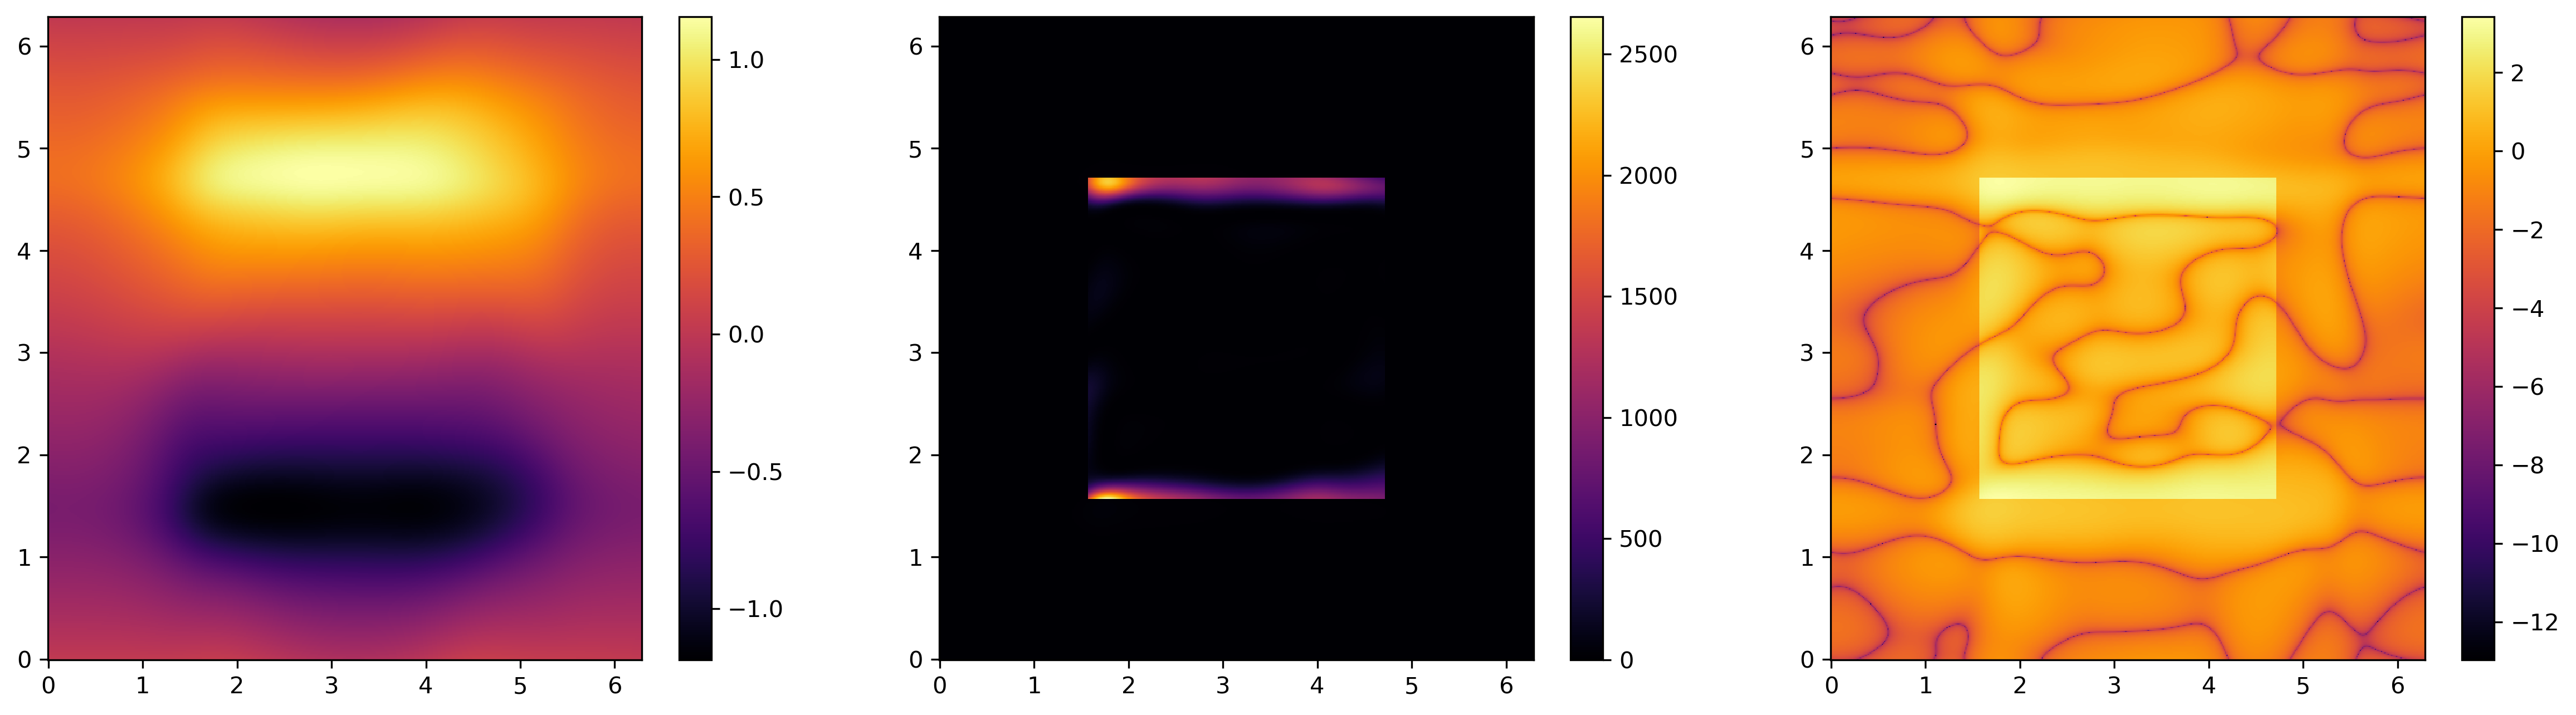

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U2.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_2.reshape(N, N).detach().cpu(), cmap='inferno')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], np.log10(error_2.reshape(N, N).detach().cpu()), cmap='inferno')
fig.colorbar(pos3, ax=axs[2])

In [29]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])
x_rot = torch.fliplr(x)
x_rot[:,1] = -x_rot[:,1]

_, q2, gH = PDE_loss_dual(x, net_dual, A_inv, H1)
bound_1 = compute_estimate(areas, tri, q2, gH, L).detach()[0].item()
print(1/bound_1)

W1 = net_dual(x)
W2 = net_dual(x_rot)

bound_2 = compute_bound_dual(W1, W2, tri, x, A_inv, L)[0,0]
print(bound_2)

np.save(f'bounds/square/A_l_VNPINN_{total_params}_{N_test}.npy', (1/bound_1, bound_2))

0.618261280184209
0.6069591118361813
